In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ase
import ase.io
from ase.data import atomic_masses
from chemiscope import write_input

!rm -rf ../LJ-trajectories && mkdir ../LJ-trajectories

# Chemiscope and symmetry functions

Here is the PLUMED input for our calculation:

In [2]:
p = '''
UNITS NATURAL
coord: COORDINATIONNUMBER SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} 
cub: FCCUBIC SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} ALPHA=27
fcub: MTRANSFORM_MORE DATA=cub SWITCH={SMAP R_0=0.45 D_0=0.0 A=8 B=8}
DUMPMULTICOLVAR data=coord STRIDE=100 FILE=coord.xyz
DUMPMULTICOLVAR DATA=cub STRIDE=100 FILE=cub.xyz
DUMPMULTICOLVAR DATA=fcub STRIDE=100 FILE=fcub.xyz
'''

And some input for simplemd

In [11]:
inp = '''
inputfile interface.xyz
outputfile output.xyz
temperature 0.6
tstep 0.005
friction 1
forcecutoff 2.5
listcutoff  3.0
nstep 1000
nconfig 100 trajectory.xyz
nstat   100 energies.dat
'''

Lets now run this calculation:

In [12]:
# Make a directory to run in 
!rm -rf ../LJ-trajectories/First-run && mkdir ../LJ-trajectories/First-run
# Copy the initial configuration
!cp ../data/interface.xyz ../LJ-trajectories/First-run
# Output the plumed file
f = open("../LJ-trajectories/First-run/plumed.dat", 'w')
f.write(p)
f.close()
# Output the input to simplemd
f = open("../LJ-trajectories/First-run/in", 'w')
f.write(inp)
f.close()

# Now run PLUMED
!cd ../LJ-trajectories/First-run/ && plumed simplemd < in &> /dev/null

Be better at Python than I am kids!   

In [13]:
!grep X ../LJ-trajectories/First-run/coord.xyz | awk '{print $5}' > ../LJ-trajectories/First-run/coord.dat
coord = np.loadtxt("../LJ-trajectories/First-run/coord.dat")
!grep X ../LJ-trajectories/First-run/cub.xyz | awk '{print $5}' > ../LJ-trajectories/First-run/cub.dat
cub = np.loadtxt("../LJ-trajectories/First-run/cub.dat")
!grep X ../LJ-trajectories/First-run/fcub.xyz | awk '{print $6}' > ../LJ-trajectories/First-run/fcub.dat
fcub = np.loadtxt("../LJ-trajectories/First-run/fcub.dat")

Now lets build the chemiscope

In [14]:
# Read in the trajectory
traj = ase.io.read('../LJ-trajectories/First-run/trajectory.xyz',':')

# This constructs the dicitionary of properties for chemiscope
properties = {
    "coord": {
        "target": "atom",
        "values": coord,
        "description": "Coordination number of atom",
    },
    "cub": {
        "target": "atom",
        "values": cub,
        "description": "FCCCUBIC order parameter",
    },
    "fcub": {
        "target": "atom",
        "values": fcub,
        "description": "Transformed FCCUBIC order parameter",
    },
}

# This generates our chemiscope output
write_input("fccubic_chemiscope.json.gz", cutoff=1.5, frames=traj, properties=properties )

# Distribution of order parameter values

Input to PLUMED for distribution of order parameter values:

In [23]:
p = '''
UNITS NATURAL
coord: COORDINATIONNUMBER SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} 
cub: FCCUBIC SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} ALPHA=27
fcub: MTRANSFORM_MORE DATA=cub SWITCH={SMAP R_0=0.45 D_0=0.0 A=8 B=8}
coord_histo: HISTOGRAM DATA=coord STRIDE=10 GRID_MIN=2 GRID_MAX=15 GRID_BIN=100 KERNEL=DISCRETE
cub_histo: HISTOGRAM DATA=cub STRIDE=10 GRID_MIN=-1 GRID_MAX=1 GRID_BIN=100 KERNEL=DISCRETE
fcub_histo: HISTOGRAM DATA=fcub STRIDE=10 GRID_MIN=0 GRID_MAX=1 GRID_BIN=100 KERNEL=DISCRETE
DUMPGRID GRID=coord_histo FILE=coord_histo.dat
DUMPGRID GRID=cub_histo FILE=cub_histo.dat
DUMPGRID GRID=fcub_histo FILE=fcub_histo.dat
'''

Input for MD simulation

In [24]:
inp = '''
inputfile interface.xyz
outputfile output.xyz
temperature 0.6
tstep 0.005
friction 1
forcecutoff 2.5
listcutoff  3.0
nstep 10000
nconfig 100 trajectory.xyz
nstat   100 energies.dat
'''

Run the calculation

In [25]:
# Make a directory to run in 
!rm -rf ../LJ-trajectories/Distribution && mkdir ../LJ-trajectories/Distribution
# Copy the initial configuration
!cp ../data/interface.xyz ../LJ-trajectories/Distribution
# Output the plumed file
f = open("../LJ-trajectories/Distribution/plumed.dat", 'w')
f.write(p)
f.close()
# Output the input to simplemd
f = open("../LJ-trajectories/Distribution/in", 'w')
f.write(inp)
f.close()

# Now run PLUMED
!cd ../LJ-trajectories/Distribution && plumed simplemd < in &> /dev/null

Now make the figure

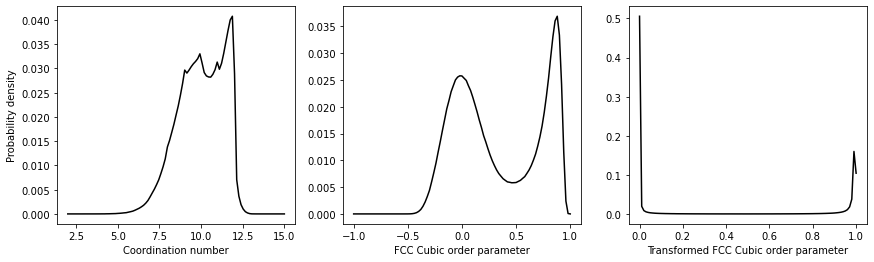

In [30]:
coord = np.loadtxt("../LJ-trajectories/Distribution/coord_histo.dat")
cub = np.loadtxt("../LJ-trajectories/Distribution/cub_histo.dat")
fcub = np.loadtxt("../LJ-trajectories/Distribution/fcub_histo.dat")

fig, ax = plt.subplots(  1, 3 )
plt.subplots_adjust( right=2 )
ax[0].plot( coord[:,0], coord[:,1], 'k-' )
ax[1].plot( cub[:,0], cub[:,1], 'k-' )
ax[2].plot( fcub[:,0], fcub[:,1], 'k-' )
ax[0].set_ylabel('Probability density')
ax[0].set_xlabel("Coordination number")
ax[1].set_xlabel("FCC Cubic order parameter")
ax[2].set_xlabel("Transformed FCC Cubic order parameter")
plt.savefig("masterclass-21-6-order-params.png", bbox_inches='tight')


# Tracking the number of solid atoms

Lets start by calculating the average values of the order parameters for the two phases here is the plumed input:

In [3]:
p='''
UNITS NATURAL
coord: COORDINATIONNUMBER SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} MEAN 
cub: FCCUBIC SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} ALPHA=27 MEAN
fcub: MTRANSFORM_MORE DATA=cub SWITCH={SMAP R_0=0.45 D_0=0.0 A=8 B=8} MEAN
acoord: AVERAGE ARG=coord.mean STRIDE=10
acub: AVERAGE ARG=cub.mean STRIDE=10 
afcub: AVERAGE ARG=fcub.mean STRIDE=10
PRINT ARG=coord.mean,cub.mean,fcub.mean,acoord,acub,afcub STRIDE=10 FILE=colvar
'''

inp = '''
inputfile interface.xyz
outputfile output.xyz
temperature 0.6
tstep 0.005
friction 1
forcecutoff 2.5
listcutoff  3.0
nstep 10000
nconfig 1000 trajectory.xyz
nstat   1000 energies.dat
'''

Now run the calculation for the solid and liquid (should do block averaging here to get the averages with suitably small error bars if you are doing this properly)


In [12]:
# Make a directory to run in 
!rm -rf ../LJ-trajectories/Solid && mkdir ../LJ-trajectories/Solid
# Copy the initial configuration
!cp ../data/solid.xyz ../LJ-trajectories/Solid/interface.xyz
# Output the plumed file
f = open("../LJ-trajectories/Solid/plumed.dat", 'w')
f.write(p)
f.close()
# Output the input to simplemd
f = open("../LJ-trajectories/Solid/in", 'w')
f.write(inp)
f.close()

# Now run PLUMED
!cd ../LJ-trajectories/Solid && plumed simplemd < in &> /dev/null

In [5]:
# Make a directory to run in 
!rm -rf ../LJ-trajectories/Liquid && mkdir ../LJ-trajectories/Liquid
# Copy the initial configuration
!cp ../data/liquid.xyz ../LJ-trajectories/Liquid/interface.xyz
# Output the plumed file
f = open("../LJ-trajectories/Liquid/plumed.dat", 'w')
f.write(p)
f.close()
# Output the input to simplemd
f = open("../LJ-trajectories/Liquid/in", 'w')
f.write(inp)
f.close()

# Now run PLUMED
!cd ../LJ-trajectories/Liquid && plumed simplemd < in &> /dev/null

Read in the colvar files from the calculations

In [14]:
av_solid = np.loadtxt("../LJ-trajectories/Solid/colvar")
av_liquid = np.loadtxt("../LJ-trajectories/Liquid/colvar")

Lets see if we have converged these averages (values in solid are shown in black and in liquid in red). The solid lines are the averages.  The dashed lines are the instantaneous values:

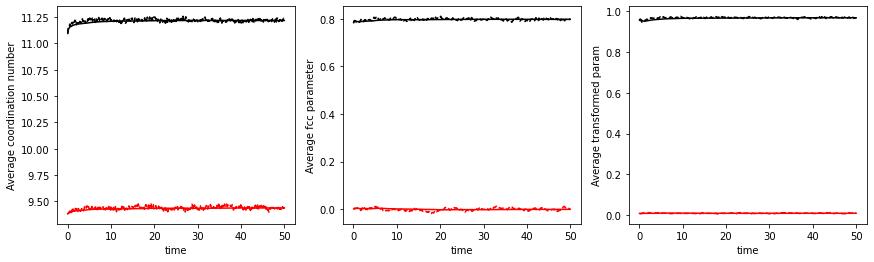

In [15]:
fig, ax = plt.subplots( 1, 3 )
plt.subplots_adjust( right=2 )
ax[0].plot( av_solid[:,0], av_solid[:,1], 'k--')
ax[0].plot( av_liquid[:,0], av_liquid[:,1], 'r--')
ax[0].plot( av_solid[:,0], av_solid[:,4], 'k-')
ax[0].plot( av_liquid[:,0], av_liquid[:,4], 'r-')
ax[0].set_xlabel('time')
ax[0].set_ylabel("Average coordination number")
ax[1].plot( av_solid[:,0], av_solid[:,2], 'k--')
ax[1].plot( av_liquid[:,0], av_liquid[:,2], 'r--')
ax[1].plot( av_solid[:,0], av_solid[:,5], 'k-')
ax[1].plot( av_liquid[:,0], av_liquid[:,5], 'r-')
ax[1].set_xlabel('time')
ax[1].set_ylabel("Average fcc parameter")
ax[2].plot( av_solid[:,0], av_solid[:,3], 'k--')
ax[2].plot( av_liquid[:,0], av_liquid[:,3], 'r--')
ax[2].plot( av_solid[:,0], av_solid[:,6], 'k-')
ax[2].plot( av_liquid[:,0], av_liquid[:,6], 'r-')
ax[2].set_xlabel('time')
ax[2].set_ylabel("Average transformed param")
plt.show()

Now run the simulation of the interface and track the number of solid atoms using the various methods.  Notice that we have the following from the text of the exercise:

$$
\Phi = \phi_s n_s + \phi_l n_l \qquad \textrm{and} \qquad N = n_s + n_l 
$$
Rearranging these expressions gives the number of solid atoms as:
$$
n_s = \frac{\Phi - \phi_l N}{\phi_s - \phi_l }
$$


In [16]:
aval = len(av_solid[:,0]) - 1
coord_m = 1 / ( av_solid[aval,1] -  av_liquid[aval,1] )
coord_c = - av_liquid[aval,1]*5184*coord_m
cub_m = 1 / ( av_solid[aval,2] -  av_liquid[aval,2] )
cub_c = - av_liquid[aval,2]*5184*coord_m
fcub_m = 1 / ( av_solid[aval,3] -  av_liquid[aval,3] )
fcub_c = - av_liquid[aval,3]*5184*coord_m

p='''
UNITS NATURAL
coord: COORDINATIONNUMBER SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} MEAN 
cub: FCCUBIC SPECIES=1-5184 SWITCH={CUBIC D_0=1.2 D_MAX=1.5} ALPHA=27 MEAN
fcub: MTRANSFORM_MORE DATA=cub SWITCH={SMAP R_0=0.45 D_0=0.0 A=8 B=8} MEAN'''
p = p + "\n ncoord: CUSTOM ARG=coord.mean PERIODIC=NO FUNC=5184*x*" + str(coord_m) + "+" + str(coord_c)
p = p + "\n ncub: CUSTOM ARG=cub.mean PERIODIC=NO FUNC=5184*x*" + str(cub_m) + "+" + str(cub_c)
p = p + "\n nfcub: CUSTOM ARG=fcub.mean PERIODIC=NO FUNC=5184*x*" + str(fcub_m) + "+" + str(fcub_c)
p = p + "\n PRINT ARG=ncoord,ncub,nfcub STRIDE=10 FILE=colvar"


Now we can run a short trajectory of the interface:

In [17]:
# Make a directory to run in 
!rm -rf ../LJ-trajectories/Interface && mkdir ../LJ-trajectories/Interface
# Copy the initial configuration
!cp ../data/interface.xyz ../LJ-trajectories/Interface
# Output the plumed file
f = open("../LJ-trajectories/Interface/plumed.dat", 'w')
f.write(p)
f.close()
# Output the input to simplemd
f = open("../LJ-trajectories/Interface/in", 'w')
f.write(inp)
f.close()

# Now run PLUMED
!cd ../LJ-trajectories/Interface && plumed simplemd < in &> /dev/null

And make a plot of the number of solid atom calculated in the various different ways

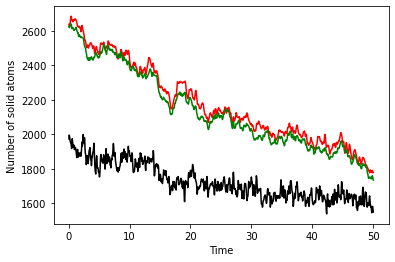

In [18]:
nsolid = np.loadtxt("../LJ-trajectories/Interface/colvar")

plt.plot( nsolid[:,0], nsolid[:,1], 'k-' )
plt.plot( nsolid[:,0], nsolid[:,2], 'r-' )
plt.plot( nsolid[:,0], nsolid[:,3], 'g-' )
plt.xlabel("Time")
plt.ylabel('Number of solid atoms')
plt.savefig("masterclass-21-6-solid-liquid.png")